# Kenar Entertainment Sentiment Analysis

## Set up environment

In [ ]:
import os
from dotenv import find_dotenv, load_dotenv
import tweepy
import pandas as pd
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


from util import *

nltk.download('vader_lexicon')
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
API_KEY = os.getenv("API_KEY")
API_KEY_SECRET = os.getenv("API_KEY_SECRET")
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
ACCESS_TOKEN_SECRET = os.getenv("ACCESS_TOKEN_SECRET")

: 

## Authentication

### API v1.1

In [2]:
# auth1 = tweepy.OAuth1UserHandler(API_KEY, API_KEY_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
# api1 = tweepy.API(auth1)

# tweets = api1.home_timeline(count = 5)
# for tweet in tweets:
#     print(tweet.text, '\n')

### API v2.0

In [3]:
api2 = tweepy.Client(bearer_token=BEARER_TOKEN)

query = '#chelsea -is:retweet lang:en'

# tweets = api2.search_recent_tweets(query=query, tweet_fields = ['context_annotations', 'created_at'], max_results=10)
# for tweet in tweets.data:
#     print('\n___Tweet Text___\n' , tweet.text)

paginator = tweepy.Paginator(
    api2.search_recent_tweets,
    query = query,
    max_results=100,
    limit=10
)

tweet_list = []

for tweet in paginator.flatten():
    tweet_list.append(tweet)

In [4]:
tweet_list_df = pd.DataFrame(tweet_list)
tweet_list_df = pd.DataFrame(tweet_list_df['text'])
tweet_list_df.head(5)

,text
0,AVIATION INDUSTRIES\n\nhttps://t.co/zUqpQU9LhE...
1,CHELSEA TO REIGNITE THEIR INTEREST IN BARCELON...
2,"Property of the Week: Two Bedroom Apartment, L..."
3,"ENDRICK TAKES ENGLISH LESSONS, MOUNT TURNS DOW..."
4,🙌🤩 #Chelseafollowtrain 🚂 ❗️FOLLOW EVERYON...


## Data Preprocessing

In [5]:
cleaned_tweets = []

for tweet in tweet_list_df['text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

In [6]:
tweet_list_df['cleaned'] = pd.DataFrame(cleaned_tweets)
tweet_list_df.head(5)

,text,cleaned
0,AVIATION INDUSTRIES\n\nhttps://t.co/zUqpQU9LhE...,aviation industries aviation erp software avia...
1,CHELSEA TO REIGNITE THEIR INTEREST IN BARCELON...,chelsea to reignite their interest in barcelon...
2,"Property of the Week: Two Bedroom Apartment, L...",property of the week two bedroom apartment lon...
3,"ENDRICK TAKES ENGLISH LESSONS, MOUNT TURNS DOW...",endrick takes english lessons mount turns down...
4,🙌🤩 #Chelseafollowtrain 🚂 ❗️FOLLOW EVERYON...,chelseafollowtrain follow everyone that comme...


## Generate Sentiment Labels

In [7]:
#Calculating Negative, Positive, Neutral and Compound values

tweet_list_df[['polarity', 'subjectivity']] = tweet_list_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list_df['cleaned'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweet_list_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_list_df.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list_df.loc[index, 'sentiment'] = "neutral"
    tweet_list_df.loc[index, 'neg'] = neg
    tweet_list_df.loc[index, 'neu'] = neu
    tweet_list_df.loc[index, 'pos'] = pos
    tweet_list_df.loc[index, 'compound'] = comp

tweet_list_df.head(5)

C:\Users\User\AppData\Local\Temp\ipykernel_5376\1897720740.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, row in tweet_list_df['cleaned'].iteritems():


,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,AVIATION INDUSTRIES\n\nhttps://t.co/zUqpQU9LhE...,aviation industries aviation erp software avia...,0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000
1,CHELSEA TO REIGNITE THEIR INTEREST IN BARCELON...,chelsea to reignite their interest in barcelon...,0.000000,0.000000,positive,0.0,0.833,0.167,0.7184
2,"Property of the Week: Two Bedroom Apartment, L...",property of the week two bedroom apartment lon...,0.375000,0.516667,positive,0.0,0.830,0.170,0.7783
3,"ENDRICK TAKES ENGLISH LESSONS, MOUNT TURNS DOW...",endrick takes english lessons mount turns down...,-0.077778,0.144444,neutral,0.0,1.000,0.000,0.0000
4,🙌🤩 #Chelseafollowtrain 🚂 ❗️FOLLOW EVERYON...,chelseafollowtrain follow everyone that comme...,0.000000,0.000000,neutral,0.0,1.000,0.000,0.0000


## Sentiment Visualization

In [8]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweet_list_df_negative = tweet_list_df[tweet_list_df["sentiment"]=="negative"]
tweet_list_df_positive = tweet_list_df[tweet_list_df["sentiment"]=="positive"]
tweet_list_df_neutral = tweet_list_df[tweet_list_df["sentiment"]=="neutral"]

### Donut Chart

In [9]:
#Function for count_values_in single columns

def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [10]:
#Count_values for sentiment
count_values_in_column(tweet_list_df,"sentiment")

,Total,Percentage
positive,599,59.9
neutral,251,25.1
negative,150,15.0


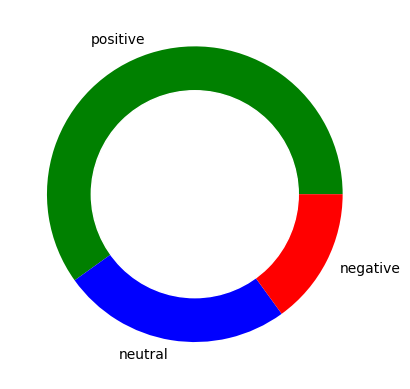

In [11]:
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")
# names= pc.index
# size=pc["Percentage"]

names= pichart.index
size=pichart["Percentage"]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### World Cloud

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Coding/Machine Learning/Kenar Ent Sentiment Analysis
!ls

ModuleNotFoundError: No module named 'google.colab'